# Convolutional Neural Network


In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))

# Device Configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("This notebook use [%s]."%(device))

PyTorch version:[1.7.0+cu101].
This notebook use [cuda:0].


# Set hyper-parameter

In [2]:
EPOCHS = 10
BATCH_SIZE=256
LEARNING_RATE=0.001

# Prepare dataset

In [3]:
mnist_train = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
print('Dome')

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
Dome


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Define Model

In [4]:
class Model(nn.Module):
    def __init__(self, input_size = [1, 28, 28], hidden_size=[32,64], num_classes=10, init_weight="he", init_bias="zero"):
        super(Model, self).__init__()

        self.init_weight = init_weight
        self.init_bias = init_bias

        layer_list = []
        prev_channel = input_size[0]
        
        for idx in range(len(hidden_size)):
            layer_list.append(nn.Conv2d(prev_channel, hidden_size[idx], kernel_size=3, stride=1, padding=1))
            layer_list.append(nn.BatchNorm2d(hidden_size[idx]))
            layer_list.append(nn.ReLU(True))
            layer_list.append(nn.MaxPool2d(kernel_size=2, stride=2))
            prev_channel = hidden_size[idx]
        
        layer_list.append(nn.Flatten())
        feature_size = int(input_size[1]/ 2**len(hidden_size))
        layer_list.append(nn.Linear(feature_size*feature_size*prev_channel, 10))
        
        self.net = nn.Sequential(*layer_list)

        self.init_params()

    def init_params(self):
        
        init_weight_method = {
        "he": nn.init.kaiming_normal_, 
        "xavier": nn.init.xavier_normal_
        }
        assert self.init_weight in init_weight_method.keys(), f'Select the weight initialization method in {list(init_weight_method.keys())}'
        
        init_bias_method = {
            "zero": nn.init.zeros_, 
            "uniform": nn.init.uniform_
        }
        assert self.init_bias in init_bias_method.keys(), f'Select the bias initialization method in {list(init_bias_method.keys())}'

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weight_method[self.init_weight](m.weight)
                init_bias_method[self.init_bias](m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, X):
        return self.net(X)

model = Model(hidden_size=[16, 32, 64]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Calculate Parameters

In [5]:
total_params = 0
for param_name, param in model.named_parameters():
    if param.requires_grad:
        total_params += len(param.reshape(-1))
print(f"Number of Total Parameters: {total_params:,d}")

Number of Total Parameters: 29,290


# Define help function

In [6]:
def test_eval(model, data_iter, batch_size):
    with torch.no_grad():
        test_loss = 0
        total = 0
        correct = 0
        model.eval()
        for batch_img, batch_lab in data_iter:
            X = batch_img.view(-1, 1, 28, 28).to(device)
            Y = batch_lab.to(device)
            y_pred = model(X)
            _, predicted = torch.max(y_pred.data, 1)
            correct += (predicted == Y).sum().item()
            total += batch_img.size(0)
        val_acc = (100 * correct / total)
        model.train()
    return val_acc

# Train model

In [7]:
print_every = 1
print("Start training !")
# Training loop
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_img, batch_lab in train_iter:

        X = batch_img.view(-1, 1, 28, 28).to(device)
        Y = batch_lab.to(device)
        
        # Inference & Calculate los
        y_pred = model.forward(X)
        loss = criterion(y_pred, Y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_val_sum += loss
        
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        # accr_val = M.test(x_test, y_test, batch_size)
        loss_val_avg = loss_val_sum / len(train_iter)
        accr_val = test_eval(model, test_iter, BATCH_SIZE)
        print(f"epoch:[{epoch+1}/{EPOCHS}] cost:[{loss_val_avg:.3f}] test_accuracy:[{accr_val:.3f}]")
print("Training Done !")

Start training !
epoch:[1/10] cost:[0.307] test_accuracy:[97.580]
epoch:[2/10] cost:[0.064] test_accuracy:[98.290]
epoch:[3/10] cost:[0.044] test_accuracy:[98.700]
epoch:[4/10] cost:[0.034] test_accuracy:[98.880]
epoch:[5/10] cost:[0.027] test_accuracy:[99.040]
epoch:[6/10] cost:[0.022] test_accuracy:[98.890]
epoch:[7/10] cost:[0.019] test_accuracy:[99.040]
epoch:[8/10] cost:[0.015] test_accuracy:[99.020]
epoch:[9/10] cost:[0.013] test_accuracy:[98.970]
epoch:[10/10] cost:[0.011] test_accuracy:[99.050]
Training Done !


# Test Model

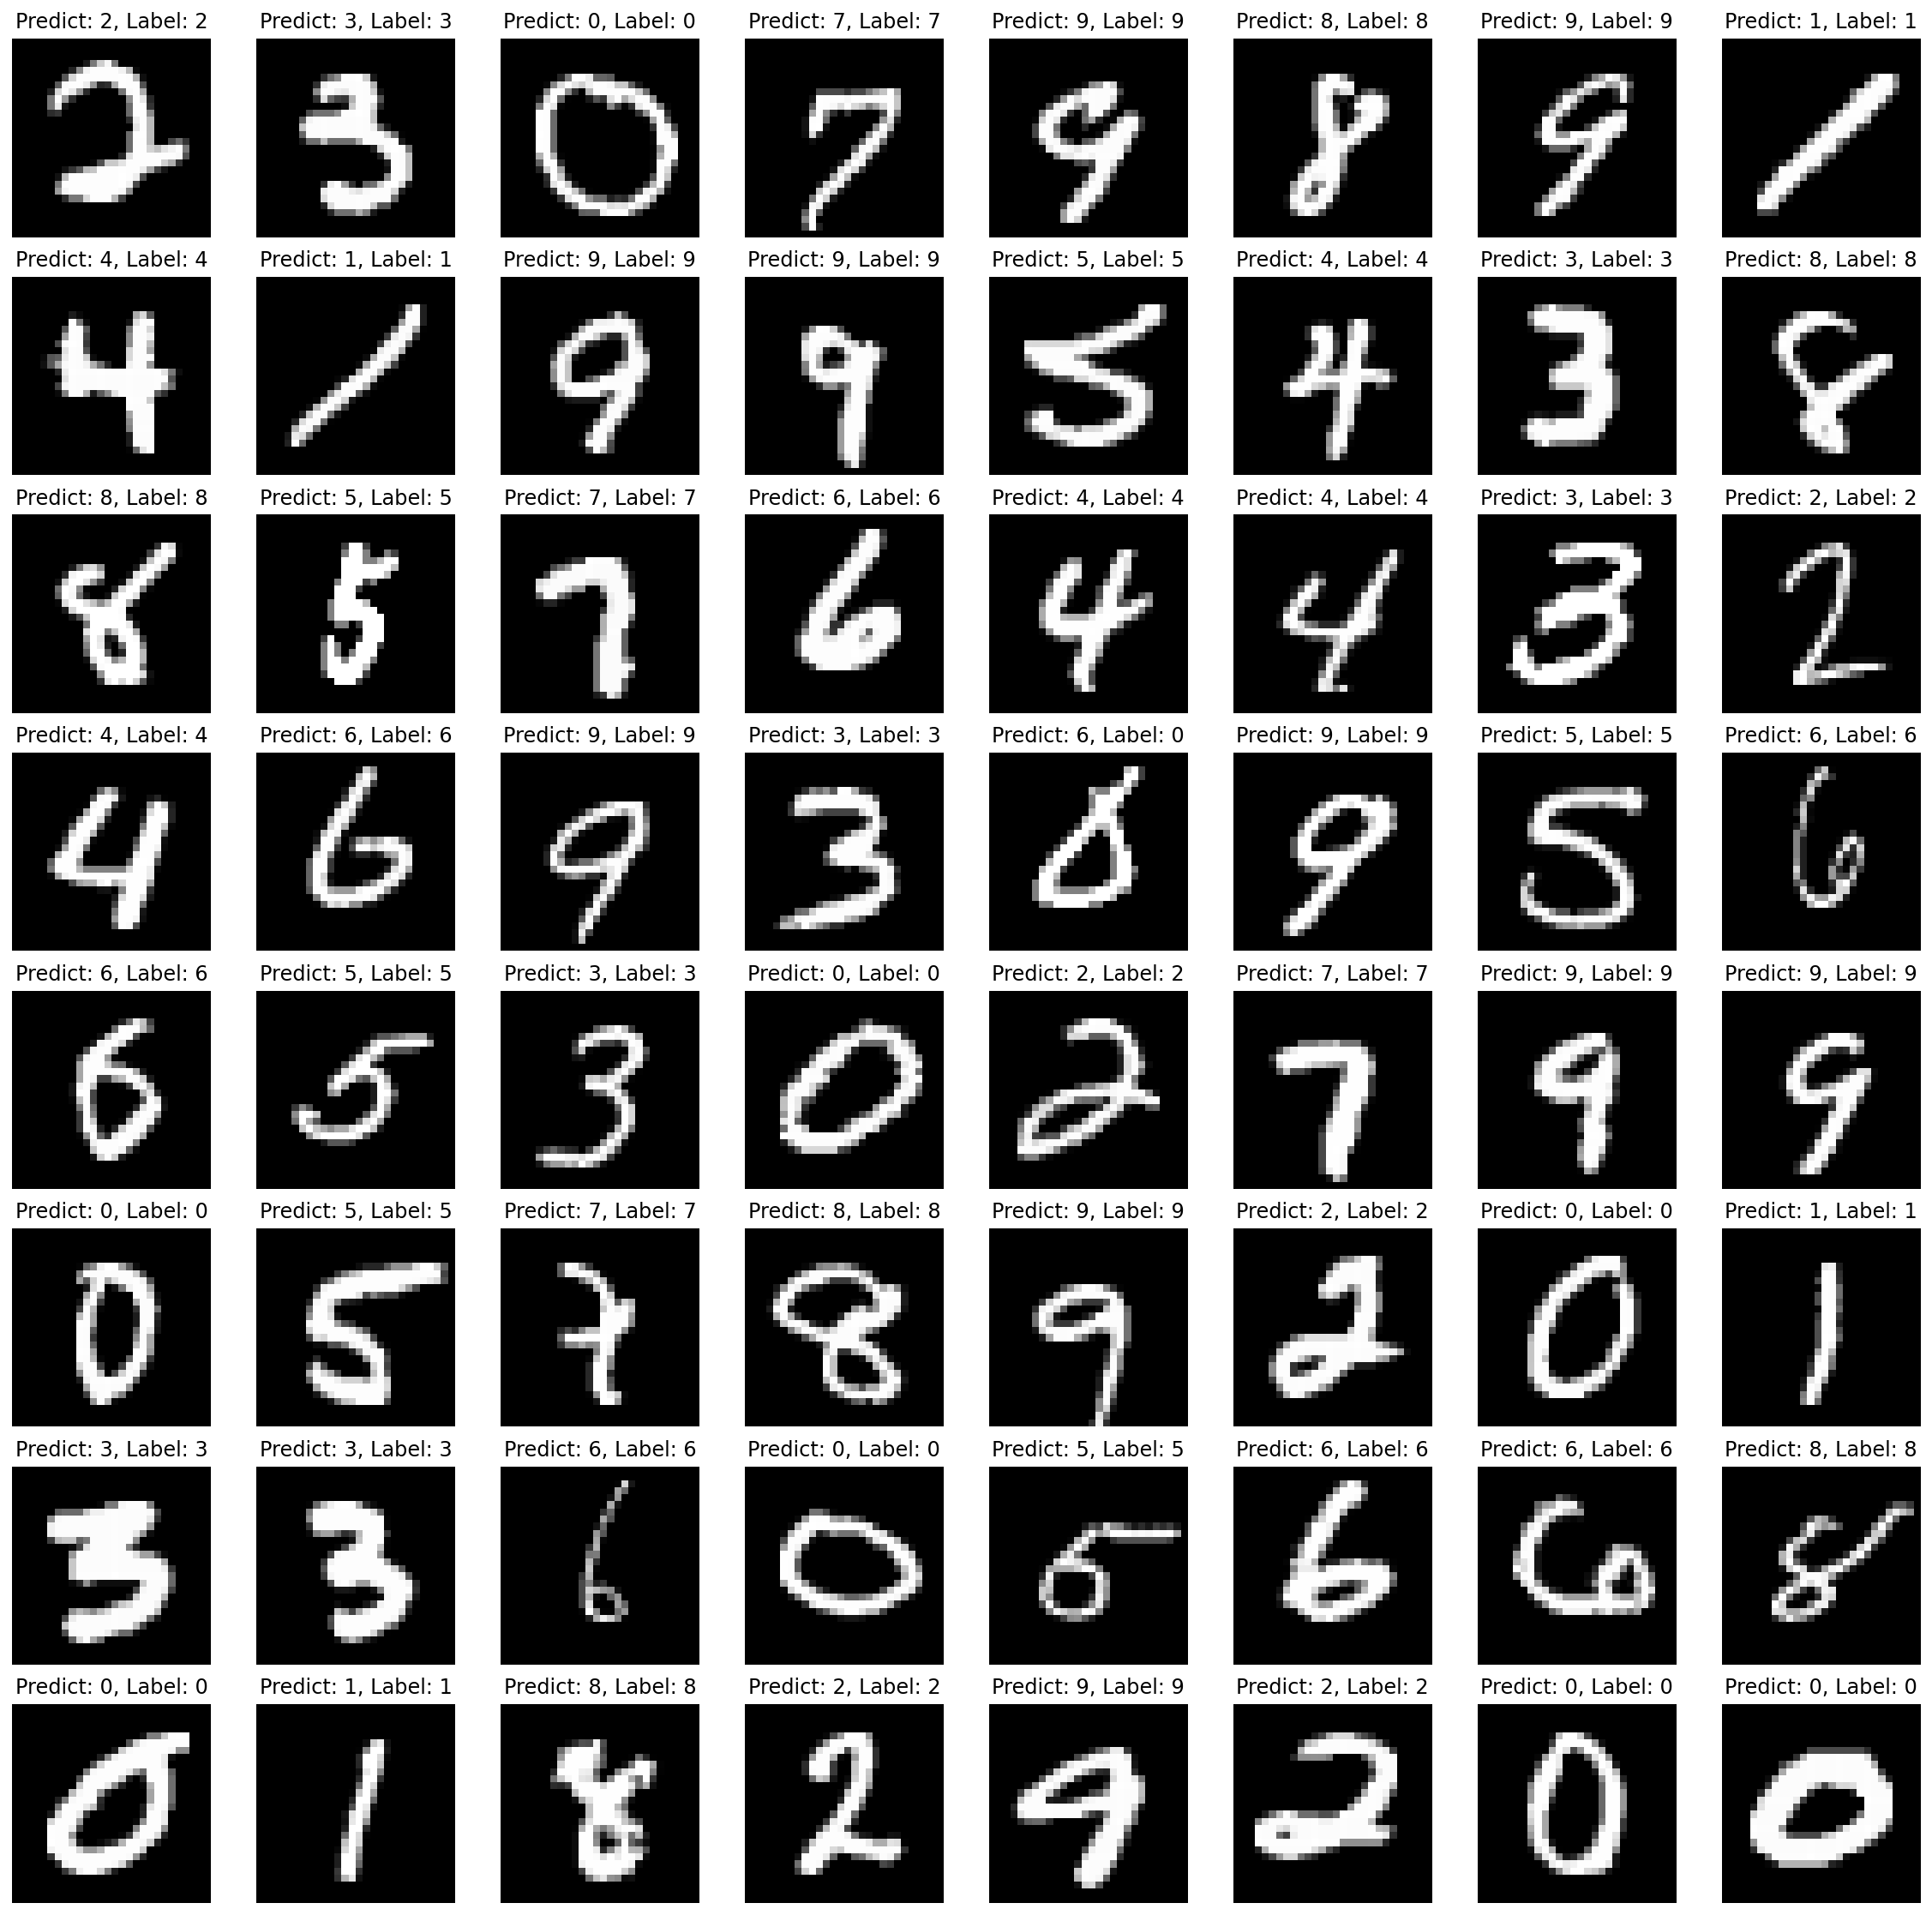

In [8]:
n_sample = 64
sample_indices = np.random.choice(len(mnist_test.targets), n_sample, replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]

with torch.no_grad():
    model.eval()
    y_pred = model.forward(test_x.view(-1, 1, 28, 28).type(torch.float).to(device))
    model.train()
    
y_pred = y_pred.argmax(axis=1)

plt.figure(figsize=(20, 20))

for idx in range(n_sample):
    plt.subplot(8, 8, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title(f"Predict: {y_pred[idx]}, Label: {test_y[idx]}")

plt.show()